In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = '../data/'
df = pd.read_csv(DATA_DIR + 'Most-Recent-Cohorts-Institution.csv', low_memory=False)

In [3]:
df = df.replace('PrivacySuppressed', np.nan)

In [4]:
df.shape

(6543, 3232)

In [5]:
nan_percentage = df.isna().mean()

# Filter out columns with more than 30% NaN values
df_cleaned = df.loc[:, nan_percentage <= 0.3].copy()


In [6]:
df_cleaned.shape

(6543, 689)

In [7]:
print(len(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('float64')]))
print(len(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('int64')]))
print(len(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('object')]))

363
15
311


In [8]:
# Find columns which cannot be coerced to object dtype. 
# These are actual categorical columns of potential interest.
err_cols = set()
for col in df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('object')]:
    try:
        pd.to_numeric(df_cleaned[col], errors='raise')
    except:
        err_cols.add(col)


In [9]:
# Coerce whatever columns which can be coerced. These are numeric columns.
for column in df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('object')]:
    if column not in err_cols:
        df_cleaned.loc[:, column] = pd.to_numeric(df_cleaned[column], errors='coerce')


C:\Users\shara\AppData\Local\Temp\ipykernel_33944\561547770.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_cleaned.loc[:, column] = pd.to_numeric(df_cleaned[column], errors='coerce')


In [10]:
print(len(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('float64')]))
print(len(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('int64')]))
print(len(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('object')]))

615
15
59


In [11]:
# Borrower-Based Repayment Rate on Federal Loans: 
# BBRR[YR]_[LOAN]_[GROUP]_[STATUS]
# [YR]=1, 2, 3, or 4
# [STATUS]:
# DFTL - Default - Not paid for 360+ days
# DLNQ - Delinquent - Not paying for 31 to 360 days
# FBR - Forbearance - Temporary stop
# DFR - Deferment 
# NOPROG - Not making progress
# MAKEPROG - Making progress
# PAIDINFULL - Paid in full
# Discharged - Discharged - obligation to pay removed
# GROUP - UG, GR, UGCOMP. UGNOCOMP, GRCOMP, GRNOCOMP
# comp means completion 
# more info @ page 33-34

# questionable_cols = ['FEDSCHCD']
# ACCREDAGENCY <-- str to cat

# val_cat_cols = ['ACCREDAGENCY', 'ACCREDCODE']
# dates = ['SEPAR_DT_MDN', 'T4APPROVALDATE']
# ACCREDCODE is the code for ACCREDAGENCY, so one can be safely dropped
# IDS = ['UNITID']
# drop col = ['MDCOST_ALL', 'MDEARN_ALL'] # <== value is 16007 and 38461 respectively for all rows!


In [12]:
num_cols = set(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('float64')])
cat_cols = set(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('object')]) | set(df_cleaned.columns[df_cleaned.dtypes.values == np.dtype('int64')])

cat_cols_to_drop = set([
    'FEDSCHCD', 'MDCO1ST_ALL', 'MDEARN_ALL',# no idea what these are
    'ACCREDAGENCY',                         # duplicate of ACCREDCODE
    'SEPAR_DT_MDN', 'T4APPROVALDATE',       # dates
    'INSTURL', 'NPCURL',                    # urls
    'UNITID',                               # ID column
    'ADDR', 'ZIP',                          # institute address
    'INSTNM'                                # institute name
])
cat_cols -= cat_cols_to_drop
cat_cols = [c for c in cat_cols if not c.startswith('BBRR')] # dropping BBRR for now
num_cols = [c for c in num_cols if not c.startswith('BBRR')]

In [13]:
# fill all num cols by median values
for column in df_cleaned[num_cols].columns:
    median_value = df_cleaned[column].median()
    df_cleaned[column].fillna(median_value, inplace=True)

# fill all cat cols by most frequent values
for column in df_cleaned[cat_cols].columns:
    mode_value = df_cleaned[column].mode()[0]
    df_cleaned[column].fillna(mode_value, inplace=True)

In [14]:
df_cleaned = df_cleaned[num_cols + cat_cols]

In [15]:
df_cleaned.isna().sum().sum()

0

In [16]:
# target column = 'DEBT_MDN'

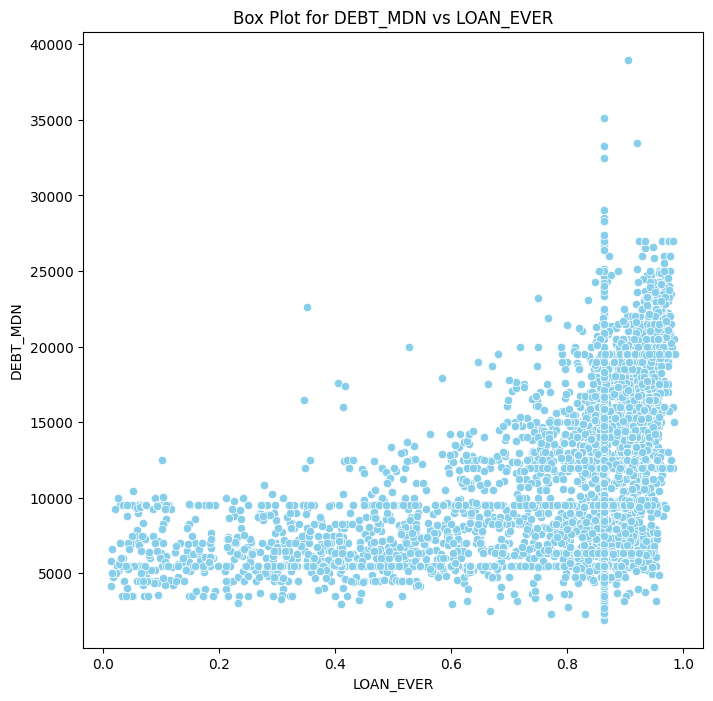

In [17]:
plt.figure(figsize=(8, 8))  # Set the figure size
sns.scatterplot(data=df_cleaned, x='LOAN_EVER', y='DEBT_MDN', color='skyblue')
plt.title(f'Box Plot for DEBT_MDN vs LOAN_EVER')
plt.show()

<Axes: ylabel='Frequency'>

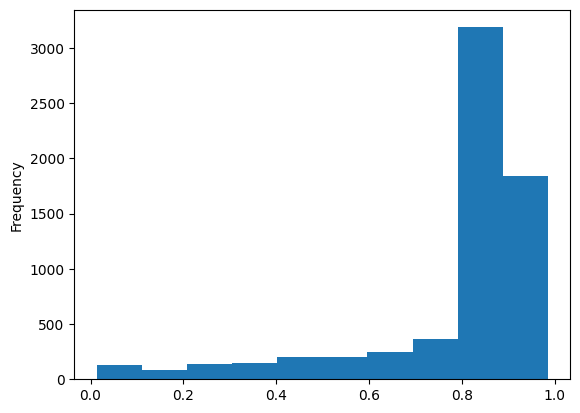

In [18]:
df_cleaned['LOAN_EVER'].plot.hist()

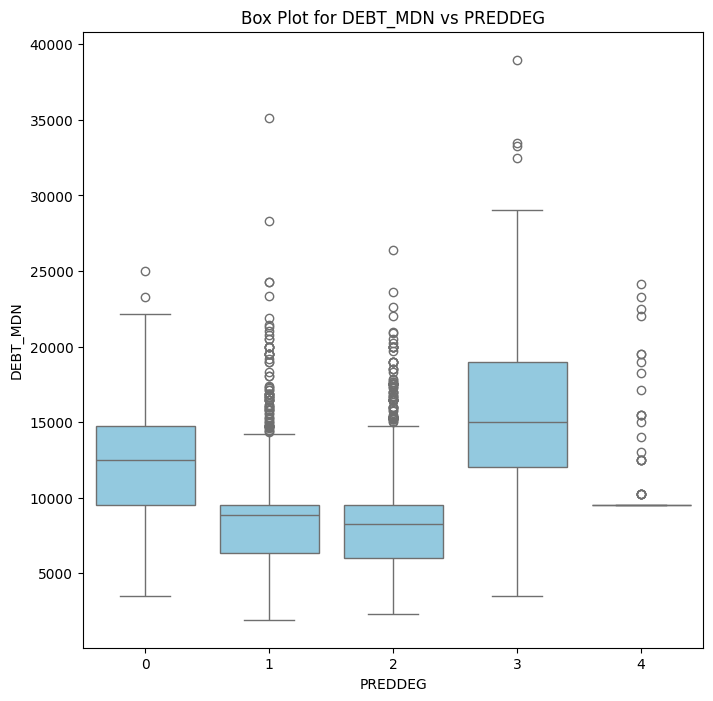

In [19]:
plt.figure(figsize=(8, 8))  # Set the figure size
sns.boxplot(data=df_cleaned, x='PREDDEG', y='DEBT_MDN', color='skyblue')
plt.title(f'Box Plot for DEBT_MDN vs PREDDEG')
plt.show()

In [20]:
df_cleaned.to_csv(DATA_DIR+'cleaned.csv', index=False)


In [21]:
df_cleaned.select_dtypes([np.object_])

,ACCREDCODE,CONTROL_PEPS,CITY,STABBR
0,SACSCC,Public,Normal,AL
1,SACSCC,Public,Birmingham,AL
2,SACSCC,Private Nonprofit,Montgomery,AL
3,SACSCC,Public,Huntsville,AL
4,SACSCC,Public,Montgomery,AL
...,...,...,...,...
6538,MSACHE,Public,York,PA
6539,MSACHE,Public,Malvern,PA
6540,MSACHE,Public,Middletown,PA
6541,MSACHE,Public,Media,PA


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_cleaned_numeric = df_cleaned.select_dtypes([np.number])
x = df_cleaned_numeric.values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=df_cleaned_numeric.shape[1])
pca.fit_transform(x)
exp_var_ratio = pca.explained_variance_ratio_
len(df_cleaned_numeric.columns)

591

Text(0, 0.5, 'Cumulative Explained Variance')

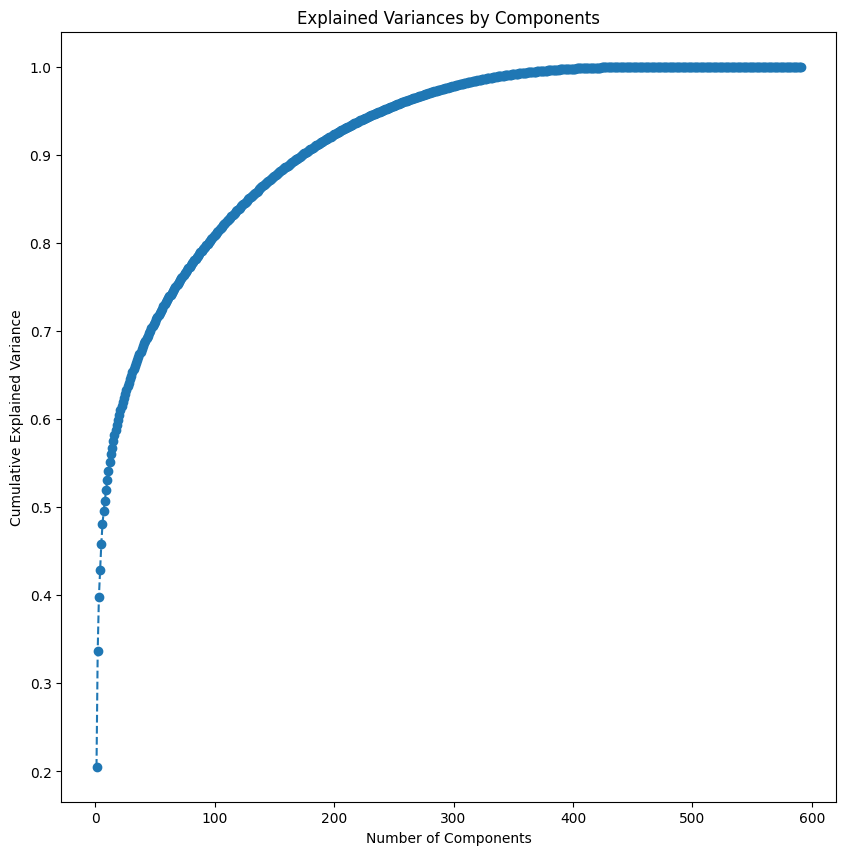

In [23]:
# visualizing the explained variance by individual components
plt.figure(figsize = (10, 10))
plt.plot(range(1, df_cleaned_numeric.shape[1] + 1), exp_var_ratio.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [24]:
# finding the least number of components that can explain more than 90% variance
sum = 0
for ix, i in enumerate(exp_var_ratio):
  sum = sum + i
  if(sum > 0.90):
    print("Number of PCs that explain at least 90% variance: ", ix + 1)
    break

Number of PCs that explain at least 90% variance:  174


In [25]:
pc_names = ['PC' + str(i+1) for i in range(174)]
pca_df = pd.DataFrame(pca.components_[:, :174], columns=pc_names, index=df_cleaned_numeric.columns)
pca_df